<a href="https://colab.research.google.com/github/weisheik/DeepLearning-Jumpstart/blob/master/Spectral_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wei Sheik's Spectral Learning Project
This project investigates whether learning is more effective/specific by removing low frequencies in grayscale images?

The idea is to train the InceptionV3 with grayscale images, then compare with spectral filtered images. The purpose of using grayscale image is to eliminate the factor of colors in classifying the objects. 

## Testing Colab GPU

In [ ]:
import tensorflow.keras
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

2.3.0
2.4.0


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Download the Flowers' Dataset

In [ ]:
!wget -qq https://www.dropbox.com/s/pcv5wpk0ybsohib/flowers.zip
!unzip -qq flowers.zip
!rm flowers.zip
!rm -r __MACOSX
!ls flowers

daisy  dandelion  rose	sunflower  tulip


### _Create DataFrame structure from raw files_

In [ ]:
import os, json
import glob
import pandas as pd

In [ ]:
path = './flowers'
data = []

for root, dirs, files in os.walk(path, topdown=True):
    for name in files:
        if '.jpg' not in name:
            continue
        file_name = os.path.abspath(os.path.join(root, name))
        class_name = os.path.basename(root)
        data.append((file_name, class_name))

In [ ]:
df = pd.DataFrame(data, columns=['file_name', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

df = df.sample(frac=1).reset_index(drop=True) # shuffle

In [ ]:
df.tail()
# df.shape
# df.dtypes

,file_name,class_name,class
4069,/content/flowers/dandelion/142390525_5d81a3659...,dandelion,1
4070,/content/flowers/tulip/16756198195_13b54e70b3_...,tulip,4
4071,/content/flowers/sunflower/14472246629_7237311...,sunflower,3
4072,/content/flowers/rose/14312910041_b747240d56_n...,rose,2
4073,/content/flowers/dandelion/7141013005_d2f168c3...,dandelion,1


## Apply Spectral Filtering
Next step:<br>
(1) Fix spectral_filter

In [ ]:
from tensorflow.signal import fft2d, fftshift, ifft2d, ifftshift
import numpy as np
import cv2 as cv

In [ ]:
def fspecial_gaussian(shape=(3,3), sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp(-(x*x + y*y) / (2.*sigma*sigma))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [ ]:
def spectral_filter(image):
    # Log-scale Fast Fourier Transform 
    X = fft2d(image)
    X_hat = np.log(abs(X) + 1)
    x_hat = fftshift(ifft2d(X_hat))
    
    # Gaussian filter
    M, N = x_hat.shape
    h = fspecial_gaussian([M, N], 20)
    h = cv.normalize(h, None)
    y_hat = x_hat * h
    
    # Inverse characteristic system
    Y_hat = fft2d(fftshift(y_hat))
    Y = np.multiply((np.exp(Y_hat) - 1), np.divide(X, abs(X)))
    y = np.power(abs(ifft2d(Y)), 2)
    return y, y_hat

In [ ]:
def mask_square(row, col, width):
  h = np.ones([row,col])
  h[row//2-width:row//2+width+1,col//2-width:col//2+width+1] = 0
  return h

In [ ]:
def _2D_filter(image):
    X = fftshift(fft2d(image))
    h = mask_square(X.shape[0], X.shape[1], 30)
    X = X * h    
    Y = abs(ifft2d(ifftshift(X)))
    return Y, X

In [ ]:
def _3D_filter(image):
    X = fftshift(fft2(image))
    
    M, N, P = X.shape
    for channel in range(P):
        X[M//2-30:M//2+31, N//2-30:N//2+31, channel] = 0
    
    Y = abs(ifft2(ifftshift(X)))
    return Y, X

### _Grayscale image_

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
im = cv.imread(df['file_name'][0], 0)
#im = cv.imread('lena.png', 0)
out, spectrum = _2D_filter(im)

#out, spectrum = spectral_filter(tf.cast(im, tf.complex64))

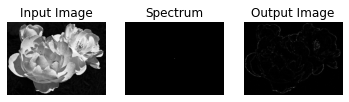

In [ ]:
plt.subplot(131)
plt.imshow(im, cmap='gray')
plt.title('Input Image'); plt.axis('off')

plt.subplot(132)
plt.imshow(abs(spectrum), cmap='gray')
plt.title('Spectrum'); plt.axis('off')

plt.subplot(133)
plt.imshow(out, cmap='gray')
plt.title('Output Image'); plt.axis('off')
plt.show()

### _Color image_

In [ ]:
im = cv.imread('lena.png')
out, spectrum = _3D_filter(im)

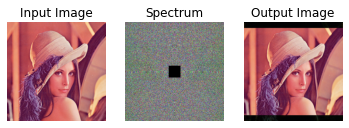

In [ ]:
plt.subplot(131)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title('Input Image'); plt.axis('off')

plt.subplot(132)
plt.imshow(abs(spectrum).astype('uint8'))
plt.title('Spectrum'); plt.axis('off')

plt.subplot(133)
plt.imshow(cv.cvtColor(out.astype('uint8'), cv.COLOR_BGR2RGB))
plt.title('Output Image'); plt.axis('off')
plt.show()

## Split Data Into Training & Validation Sets

In [ ]:
perc_train = .9  # training data percentage

df_train = df[:int(len(df)*perc_train)]
df_valid = df[int(len(df)*perc_train):]

# Shuffle
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_valid = df_valid.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train.shape, df_valid.shape
df['class_name'].unique()

[rose, sunflower, daisy, tulip, dandelion]
Categories (5, object): [rose, sunflower, daisy, tulip, dandelion]

### _Examine the data_

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

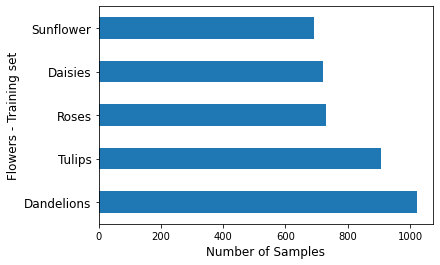

dandelion    1024
tulip         907
rose          731
daisy         720
sunflower     692
Name: class_name, dtype: int64


In [ ]:
ax = df['class_name'].value_counts().plot.barh()
ax.set_xlabel("Number of Samples", fontsize=12)
ax.set_ylabel("Flowers - Training set", fontsize=12)
ax.set_yticklabels(['Dandelions','Tulips','Roses','Daisies','Sunflower'], rotation=0, fontsize=12)
plt.show()
print(df['class_name'].value_counts())

## Convert The DataFrame Into TensorFlow Pipleline
Read an image from a file, decode it into a tensor & resize it into a fixed shape.

In [ ]:
row_img, col_img = 299, 299
num_class = 5

def _parse_function(file_name, label):
    img_str = tf.io.read_file(file_name)
    img_decode = tf.image.decode_jpeg(img_str, channels=3)
    img_resize = tf.image.resize(img_decode, [row_img, col_img])
    img_resize = tf.ensure_shape(img_resize, shape=(row_img, col_img, 3))
    label = tf.one_hot(label, num_class)
    return img_resize, label

In [ ]:
batch_size = 32

tf_train = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['file_name'].values, tf.string), 
                                               tf.cast(df_train['class'].values, tf.int32)))
tf_train = tf_train.map(_parse_function)
tf_train = tf_train.apply(tf.data.experimental.ignore_errors())
tf_train = tf_train.shuffle(1000)
tf_train = tf_train.repeat(100)
tf_train = tf_train.batch(batch_size, drop_remainder=True)

In [ ]:
tf_valid = tf.data.Dataset.from_tensor_slices((tf.cast(df_valid['file_name'].values, tf.string),
                                               tf.cast(df_valid['class'].values, tf.int32)))
tf_valid = tf_valid.map(_parse_function)
tf_valid = tf_valid.apply(tf.data.experimental.ignore_errors())
tf_valid = tf_valid.repeat()
tf_valid = tf_valid.batch(batch_size, drop_remainder=True)

In [ ]:
tf_train
# tf_valid

<BatchDataset shapes: ((32, 299, 299, 3), (32, 5)), types: (tf.float32, tf.float32)>

### _Parse spectral filtering images_
(1) Training & validation with spectral images<br>
(2) Training with spectral images & validation with color images --> Not work

In [ ]:
row_img, col_img = 299, 299
num_class = 5

def _parse_spectral(file_name, label):
    img_str = tf.io.read_file(file_name)
    img_decode = tf.io.decode_jpeg(img_str, channels=3)
    img_resize = tf.image.resize(img_decode, [row_img, col_img])
    img_gray = tf.image.rgb_to_grayscale(img_resize)
    img_spectral, spectrum = _2D_filter(tf.cast(img_gray[:,:,0], tf.complex64))
    img_spectral = img_spectral[..., tf.newaxis]
    img_spectral = tf.image.grayscale_to_rgb(img_spectral)  # restore 3 channels in grayscale
    img_spectral = tf.ensure_shape(img_spectral, shape=(row_img, col_img, 3))
    label = tf.one_hot(label, num_class)
    return img_spectral, label

In [ ]:
batch_size = 32

tfs_train = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['file_name'].values, tf.string), 
                                                tf.cast(df_train['class'].values, tf.int32)))    
tfs_train = tfs_train.map(_parse_spectral)
tfs_train = tfs_train.apply(tf.data.experimental.ignore_errors())
tfs_train = tfs_train.shuffle(1000)
tfs_train = tfs_train.repeat(100)
tfs_train = tfs_train.batch(batch_size, drop_remainder=True)

In [ ]:
tfs_valid = tf.data.Dataset.from_tensor_slices((tf.cast(df_valid['file_name'].values, tf.string),
                                               tf.cast(df_valid['class'].values, tf.int32)))
tfs_valid = tfs_valid.map(_parse_spectral)
tfs_valid = tfs_valid.apply(tf.data.experimental.ignore_errors())
tfs_valid = tfs_valid.repeat()
tfs_valid = tfs_valid.batch(batch_size, drop_remainder=True)

In [ ]:
#tfs_train
tfs_valid

<BatchDataset shapes: ((32, 299, 299, 3), (32, 5)), types: (tf.float32, tf.float32)>

In [ ]:
# Examine the data
for images, labels in tfs_train.take(1):
  img = images.numpy()
  lbl = labels.numpy()

(-0.5, 298.5, 298.5, -0.5)

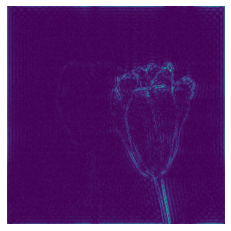

In [ ]:
plt.imshow(img[3,:,:,0])
plt.axis('off')

## Transfer Learning with InceptionV3

In [ ]:
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(row_img,col_img,3), pooling=None)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### _Add a simple head to the model for training_

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)                      # global pooling layer
x = Dense(1024, activation='relu')(x)                # fully connected layer
predict = Dense(num_class, activation='softmax')(x)  # logits layer, 5 classes of flowers

### _Create the model_

In [ ]:
model = Model(inputs=base_model.input, outputs=predict)

#### _Create spectral filtering model_

In [ ]:
model_spectral = Model(inputs=base_model.input, outputs=predict)

### _Freeze all convolutional layers, except the head_

In [ ]:
for layer in base_model.layers:
    if 'batch' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False
    
for layer in model.layers:
    print(layer.name, '\t\tTrainable =',layer.trainable)

input_1 		Trainable = False
conv2d 		Trainable = False
batch_normalization 		Trainable = True
activation 		Trainable = False
conv2d_1 		Trainable = False
batch_normalization_1 		Trainable = True
activation_1 		Trainable = False
conv2d_2 		Trainable = False
batch_normalization_2 		Trainable = True
activation_2 		Trainable = False
max_pooling2d 		Trainable = False
conv2d_3 		Trainable = False
batch_normalization_3 		Trainable = True
activation_3 		Trainable = False
conv2d_4 		Trainable = False
batch_normalization_4 		Trainable = True
activation_4 		Trainable = False
max_pooling2d_1 		Trainable = False
conv2d_8 		Trainable = False
batch_normalization_8 		Trainable = True
activation_8 		Trainable = False
conv2d_6 		Trainable = False
conv2d_9 		Trainable = False
batch_normalization_6 		Trainable = True
batch_normalization_9 		Trainable = True
activation_6 		Trainable = False
activation_9 		Trainable = False
average_pooling2d 		Trainable = False
conv2d_5 		Trainable = False
conv2d_7 		Traina

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### _Select an optimizer for model compilation_

In [ ]:
opt = Adam(lr=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### _Select the same optimizer for spectral filtering model_

In [ ]:
model_spectral.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the model

In [ ]:
step_train = int(df_train.shape[0]/batch_size)  # train size/batch size
step_valid = int(df_valid.shape[0]/batch_size)
epoch = 5

In [ ]:
print('Train steps:',step_train)
print('Validate steps:',step_valid)

Train steps: 114
Validate steps: 12


In [ ]:
history = model.fit(tf_train, 
                    steps_per_epoch=step_train,
                    epochs=epoch,
                    validation_data=tf_valid,
                    validation_steps=step_valid)

Epoch 1/5
114/114 [==============================] - 94s 824ms/step - loss: 0.6913 - accuracy: 0.7547 - val_loss: 0.3583 - val_accuracy: 0.8724
Epoch 2/5
114/114 [==============================] - 93s 814ms/step - loss: 0.3350 - accuracy: 0.8783 - val_loss: 0.3766 - val_accuracy: 0.8880
Epoch 3/5
114/114 [==============================] - 93s 814ms/step - loss: 0.2580 - accuracy: 0.9090 - val_loss: 0.3201 - val_accuracy: 0.9036
Epoch 4/5
114/114 [==============================] - 93s 813ms/step - loss: 0.2556 - accuracy: 0.9115 - val_loss: 0.2412 - val_accuracy: 0.9271
Epoch 5/5
114/114 [==============================] - 93s 812ms/step - loss: 0.1666 - accuracy: 0.9422 - val_loss: 0.2709 - val_accuracy: 0.9193


In [ ]:
metrics = model.evaluate(tf_valid, steps=step_valid)
print("Model accuracy:",metrics[1])

12/12 [==============================] - 4s 362ms/step - loss: 0.2709 - accuracy: 0.9193
Model accuracy: 0.9192708134651184


### _Fit the model with spectral images_

In [ ]:
history = model_spectral.fit(tfs_train, 
                             steps_per_epoch=step_train,
                             epochs=epoch,
                             validation_data=tfs_valid,
                             validation_steps=step_valid)

Epoch 1/5
114/114 [==============================] - 1776s 16s/step - loss: 0.9847 - accuracy: 0.6245 - val_loss: 1.0389 - val_accuracy: 0.6484
Epoch 2/5
114/114 [==============================] - 1777s 16s/step - loss: 0.7399 - accuracy: 0.7174 - val_loss: 1.0064 - val_accuracy: 0.6354
Epoch 3/5
114/114 [==============================] - 1789s 16s/step - loss: 0.6187 - accuracy: 0.7645 - val_loss: 1.0828 - val_accuracy: 0.6484
Epoch 4/5
114/114 [==============================] - 1781s 16s/step - loss: 0.5468 - accuracy: 0.7944 - val_loss: 1.1149 - val_accuracy: 0.6458
Epoch 5/5
114/114 [==============================] - 1782s 16s/step - loss: 0.4869 - accuracy: 0.8199 - val_loss: 1.1090 - val_accuracy: 0.6172


In [ ]:
metrics = model_spectral.evaluate(tfs_valid, steps=step_valid)
print("Model accuracy (spectral filtering):",metrics[1])

NameError: ignored

## Make Some Predictions

### _Download the testing dataset_

In [ ]:
!wget -qq https://www.dropbox.com/s/iupwkbumwldk9es/testing_flowers.zip
!unzip -qq testing_flowers.zip
!rm testing_flowers.zip
!rm -r __MACOSX
!ls testing_flowers

daisy01.jpg  dandelion01.jpg  rose01.jpg  sunflower01.jpg  tulip01.jpg
daisy02.jpg  dandelion02.jpg  rose02.jpg  sunflower02.jpg  tulip02.jpg
daisy03.jpg  dandelion03.jpg  rose03.jpg  sunflower03.jpg  tulip03.jpg


### _Predict the image?_

In [ ]:
from IPython.display import Image
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

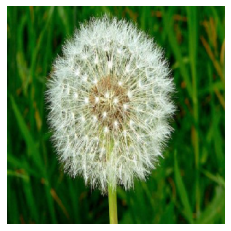

Input image shape: (1, 299, 299, 3)


In [ ]:
path_img = './testing_flowers/'
file_img = 'dandelion03.jpg'

im = image.load_img(os.path.join(path_img,file_img), target_size=(row_img,col_img))
x = image.img_to_array(im)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

plt.imshow(im); plt.axis('off')
plt.show()
print('Input image shape:',x.shape)

In [ ]:
pred = model.predict(x)
result = np.argmax(pred)

print('Predicted:',pred)
if result == 0:
    print("It's a Daisy")
elif result == 1:
    print("It's a Dandelion")
elif result == 2:
    print("It's a Rose")
elif result == 3:
    print("It's a Sunflower")
elif result == 4:
    print("It's a Tulip")

Predicted: [[1.0000000e+00 1.4995704e-14 1.1000325e-17 1.8247749e-28 1.1060342e-22]]
It's a Daisy


### _Predict the image by spectral filtering?_

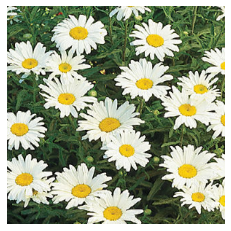

Input image shape: (1, 299, 299, 3)


In [ ]:
path_img = './testing_flowers/'
file_img = 'daisy01.jpg'

im = image.load_img(os.path.join(path_img,file_img), target_size=(row_img,col_img))
x = image.img_to_array(im)
x = np.expand_dims(x, axis=0)

plt.imshow(im); plt.axis('off')
plt.show()
print('Input image shape:',x.shape)

In [ ]:
pred = model_spectral.predict(x)
result = np.argmax(pred)

print('Predicted (spectral filtering):',pred)
if result == 0:
    print("It's a Daisy")
elif result == 1:
    print("It's a Dandelion")
elif result == 2:
    print("It's a Rose")
elif result == 3:
    print("It's a Sunflower")
elif result == 4:
    print("It's a Tulip")

Predicted (spectral filtering): [[9.6064955e-01 4.2537472e-04 1.3634187e-05 1.3300074e-02 2.5611414e-02]]
It's a Daisy
